In [1]:
import oda_api.token 
import logging
import numpy as np
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage, OdaLightCurve, OdaSpectrum
import matplotlib.pyplot as plt
import astroquery.heasarc
from astropy.wcs import WCS
from astropy.io import fits
from astroquery.simbad import Simbad
from astropy import coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.time import Time
from matplotlib.patches import Circle
from astroquery.jplhorizons import Horizons
import pandas as pd
import astropy.units as u
import json

In [2]:
logging.getLogger().setLevel(logging.WARNING)
logging.getLogger('oda_api').addHandler(logging.StreamHandler())

Load the ScWs.

In [3]:
scw = []
start = []
end = []

with open("../data/Crab-ScWs.txt", "r") as f:
    next(f)
    for line in f:
        parts = line.strip().split(", ")
        scw.append(parts[0])
        start.append(float(parts[1]))  
        end.append(float(parts[2]))  

unique_sorted_data = {}
for scw, start, end in sorted(zip(scw, start, end), key=lambda x: x[0]):
    if scw not in unique_sorted_data:  
        unique_sorted_data[scw] = (scw, start, end)

scw, start, end = map(list, zip(*unique_sorted_data.values()))
durations = [e-s for e,s in zip(end, start)]

In [4]:
crab = SkyCoord.from_name("Crab")
ra = crab.ra.deg
dec = crab.dec.deg

crab_coords = coord.SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg))

## QUERYING 

As we can see, Crab observations only happen twice per year in 3-month groups (Feb->Apr and Aug->Oct).
The idea now will be to get some longterm lightcurves over the years and see how the countrate evolves. Depending on the variability of the countrate, we will use it for flux conversion.

## IMAGES

We use asynchronous querying. We aim to get one result per month, every year. Since the ScWs only happen in two 3-month intervals per year, this will mean 6 results every year for 22 years so 120 results total. 

To choose the ScW every month, we will take the shortest one for time reasons.

In [ ]:
isot_start_times = Time(start, format='mjd').isot
isot_end_times = Time(end, format='mjd').isot
duration_seconds = [duration * 86400 for duration in durations]
year_months = [st[:7] for st in isot_start_times]

First check how many images there are if you choose one per month.

In [8]:
scw_per_month = {}

for scw_id, ym in zip(scw, year_months):
    if ym not in scw_per_month:
        scw_per_month[ym] = scw_id 

print(f"Number of SCWs if picking one per month: {len(scw_per_month)}")

Number of SCWs if picking one per month: 104


In [6]:
disp_by_date = {}
data_by_date = {}

while True:
    image_results = []

    for year_month in sorted(set(year_months)):

        filtered_scws = []
        for i, year_month_in_list in enumerate(year_months):
            if year_month_in_list == year_month:
                filtered_scws.append((scw[i], isot_start_times[i], isot_end_times[i], duration_seconds[i]))

        if not filtered_scws:
            print(f"No SCWs found for {year_month}")
            continue
        
        min_duration_scw = min(filtered_scws, key=lambda x: x[3]) # minimum duration

        # add filtering for not choosing the first 5 and last 10 ScWs of each revolution 
        # (ScWs look like RRRRPPPPSSS.001, so choose 5 < PPPP < 990)
        
        filtered_scws = [scw for scw in filtered_scws if 5 < int(scw[0][4:8]) < 990]
        if not filtered_scws:
            print(f"No SCWs found for {year_month} after filtering")
            continue

        scw_id, start_time, end_time, duration = min_duration_scw
        # print(min_duration_scw)

        par_dict = {
            "RA": ra,
            "DEC": dec,
            "E1_keV": "15",
            "E2_keV": "30",
            "T_format": "isot",
            'T1': start_time,
            'T2': end_time,
            "detection_threshold": "5",
            "instrument": "isgri",
            "osa_version": "OSA11.2",
            "product": "isgri_image",
            "product_type": "Real",
            "scw_list": [scw_id],
            'token': oda_api.token.discover_token(),
        }
        
        if scw_id not in disp_by_date:
            disp_by_date[scw_id] = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock", wait=False)
        
        _disp = disp_by_date[scw_id]
        
        data = data_by_date.get(scw_id, None)

        if data is None and not _disp.is_failed:
            if not _disp.is_submitted:
                data = _disp.get_product(**par_dict, silent=True)
            else:
                _disp.poll()

            print("Is complete ", _disp.is_complete)
            if not _disp.is_complete:
                continue
            else:
                data = _disp.get_product(**par_dict, silent=True)
                data_by_date[scw_id] = data

        image_results.append(data)

    n_complete = len([ year for year, _disp in disp_by_date.items() if _disp.is_complete ])
    print(f"complete {n_complete} / {len(disp_by_date)}")
    if n_complete == len(disp_by_date):
        print("done!")
        break
    print("not done")

Is complete  True
Is complete  True
Is complete  True
Is complete  False
Is complete  False
No SCWs found for 2004-04 after filtering
Is complete  True
Is complete  True
Is complete  True
Is complete  False
Is complete  False
Is complete  False
Is complete  True
Is complete  False
Is complete  False
Is complete  True
No SCWs found for 2006-08 after filtering
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False
Is complete  False


DispatcherException: {'cdci_data_analysis_version': '1.3.5', 'cdci_data_analysis_version_details': 'unknown', 'config': {'dispatcher-config': {'cfg_dict': {'dispatcher': {'bind_options': {'bind_host': '0.0.0.0', 'bind_port': 8000}, 'dispatcher_callback_url_base': 'https://dispatcher-staging-flux.obsuks1.unige.ch', 'dummy_cache': 'dummy-cache', 'email_options': {'bcc_receivers_email_addresses': ['vladimir.savchenko@gmail.com'], 'cc_receivers_email_addresses': [], 'email_sending_job_submitted': True, 'email_sending_job_submitted_default_interval': 1209600, 'email_sending_timeout': True, 'email_sending_timeout_default_threshold': 1, 'sender_email_address': 'postmaster@in.odahub.io', 'smtp_port': 587, 'smtp_server': 'smtp.eu.mailgun.org'}, 'matrix_options': {'matrix_message_sending_job_submitted': True, 'matrix_message_sending_job_submitted_default_interval': 5, 'matrix_message_sending_timeout': True, 'matrix_message_sending_timeout_default_threshold': 1800, 'matrix_server_url': 'https://matrix-client.matrix.org/', 'sentry_for_matrix_message_sending_check': False}, 'product_gallery_options': {'product_gallery_url': 'https://www.astro.unige.ch/mmoda/gallery'}, 'products_url': 'https://www.astro.unige.ch/mmoda/', 'renku_options': {'renku_base_project_url': 'http://renkulab.io/projects', 'renku_gitlab_repository_url': 'git@renkulab.io:astronomy/mmoda/mmoda-request.git', 'ssh_key_path': '/etc/renku-ssh-key'}}}, 'origin': {'filepath': '/dispatcher/conf/conf_env.yml', 'set_by': 'command line /pyenv/versions/3.10.11/lib/python3.10/site-packages/cdci_data_analysis/flask_app/app.py:cdci_data_analysis.flask_app.app'}}, 'plugins': {'cdci_osa_plugin': {'config_file': '/dispatcher/conf/conf.d/osa_data_server_conf.yml'}, 'cdci_polar_plugin': {'config_file': '/dispatcher/conf/conf.d/polar_data_server_conf.yml'}, 'dispatcher_plugin_antares': {'config_file': '/dispatcher/conf/conf.d/antares_data_server_conf.yml'}, 'dispatcher_plugin_gw': {'config_file': '/dispatcher/conf/conf.d/gw_data_server_conf.yml'}, 'dispatcher_plugin_integral_all_sky': {'config_file': '/pyenv/versions/3.10.11/lib/python3.10/site-packages/dispatcher_plugin_integral_all_sky/config_dir/data_server_conf.yml'}, 'dispatcher_plugin_legacysurvey': {'config_file': '/dispatcher/conf/conf.d/legacysurvey_data_server_conf.yml'}, 'dispatcher_plugin_nb2workflow': {'config_file': '/dispatcher/conf/conf.d/nb_data_server_conf.yml'}}}, 'debug_mode': 'no', 'error_message': 'please run connect() first', 'installed_instruments': ['isgri', 'jemx', 'polar', 'antares', 'gw', 'spi_acs', 'legacysurvey', 'aafrag', 'agn_cacades', 'analyse_short_astro_text', 'auger', 'crbeam', 'ctao', 'desi_legacy_survey', 'erosita', 'fermi_lat', 'gaia', 'gallery', 'hess', 'iact_simulators', 'icecube', 'combine_integral_gallery_products', 'integral_gallery_products', 'isgri_expert', 'jemx_expert', 'karabo_dirty_image_sim', 'lightcurve_analysis', 'lst', 'magic', 'meerkat_galaxy_clusters', 'mwa', 'photoz_euclid', 'rosat', 'sed', 'sgwb', 'spectral_analysis', 'stix_mwa_solar_activity', 'synch_ic_brems', 'tool_plot_candidates_pos_photoz', 'wise'], 'message': 'request not valid', 'oda_api_version': '1.2.38'}

With error handling:

In [9]:
disp_by_date = {} 
data_by_date = {}

while True:
    image_results = []

    for year_month in sorted(set(year_months)):
        filtered_scws = [
            (scw[i], isot_start_times[i], isot_end_times[i], duration_seconds[i])
            for i, year_month_in_list in enumerate(year_months)
            if year_month_in_list == year_month
        ]

        if not filtered_scws:
            print(f"No SCWs found for {year_month}")
            continue

        # Sort SCWs by duration (smallest first)
        filtered_scws.sort(key=lambda x: x[3]) 

        # add filtering for not choosing the first 5 and last 10 ScWs of each revolution 
        # (ScWs look like RRRRPPPPSSS.001, so choose 5 < PPPP < 990)
        
        filtered_scws = [scw for scw in filtered_scws if 5 < int(scw[0][4:8]) < 990]
        if not filtered_scws:
            print(f"No SCWs found for {year_month} after filtering")
            continue

        for scw_id, start_time, end_time, duration in filtered_scws:
            print(f"Trying SCW {scw_id} with duration {duration} for {year_month}")

            par_dict = {
                "RA": ra,
                "DEC": dec,
                "E1_keV": "15",
                "E2_keV": "30",
                "T_format": "isot",
                'T1': start_time,
                'T2': end_time,
                "detection_threshold": "5",
                "instrument": "isgri",
                "osa_version": "OSA11.2",
                "product": "isgri_image",
                "product_type": "Real",
                "scw_list": [scw_id],
                'token': oda_api.token.discover_token(),
            }

            if scw_id not in disp_by_date:
                disp_by_date[scw_id] = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock", wait=False)

            _disp = disp_by_date[scw_id]

            data = data_by_date.get(scw_id, None)

            if data is None and not _disp.is_failed:
                try:
                    if not _disp.is_submitted:
                        data = _disp.get_product(**par_dict, silent=True)
                    else:
                        _disp.poll()

                    if not _disp.is_complete:
                        continue  # Retry with the next SCW
                        # raise ValueError("Query incomplete")  # Force skipping the month

                    # Query successful, store the data
                    data = _disp.get_product(**par_dict, silent=True)
                    data_by_date[scw_id] = data
                    image_results.append(data)
                    break  # Stop trying other SCWs for this month

                except Exception as e:
                    print(f"Query failed for SCW {scw_id}: {e}")
                    continue  # Try the next SCW

        else:
            print(f"All SCWs failed for {year_month}, skipping.")
            # print(f"Skipping {year_month} due to errors.")

    n_complete = len([year for year, _disp in disp_by_date.items() if _disp.is_complete])
    print(f"complete {n_complete} / {len(disp_by_date)}")

    if n_complete == len(disp_by_date):
        print("done!")
        break
    print("not done")

Trying SCW 004400850010.001 with duration 1748.0009259888902 for 2003-02
Trying SCW 005100600010.001 with duration 2199.001089250669 for 2003-03
Trying SCW 005800240010.001 with duration 2200.001117773354 for 2003-04
Trying SCW 010200140010.001 with duration 2199.001089250669 for 2003-08
Trying SCW 017000900010.001 with duration 1793.0009924573824 for 2004-03
No SCWs found for 2004-04 after filtering
Trying SCW 022500140010.001 with duration 2200.001204526052 for 2004-08
Trying SCW 023900810010.001 with duration 1799.0010227775201 for 2004-09
Trying SCW 024200100010.001 with duration 2200.001221499406 for 2004-10
Trying SCW 030000080010.001 with duration 1799.0009888308123 for 2005-03
Trying SCW 030100150010.001 with duration 2170.001266663894 for 2005-04
Trying SCW 035200140010.001 with duration 3572.001953353174 for 2005-08
Trying SCW 035200470010.001 with duration 3571.001977007836 for 2005-09
Trying SCW 036501030010.001 with duration 1236.000807560049 for 2005-10
Trying SCW 0422006

query failed!
Remote server message:-> Error when getting query products
Remote server error_message-> Instrument: isgri, product: isgri_image

The support team has been notified, and we are investigating to resolve the issue as soon as possible

If you are willing to help us, please use the "Write a feedback" button below. We will make sure to respond to any feedback provided
Remote server debug_message-> DDAException('AnalysisException:ProduceDisabledException("not allowed to produce but has to! at [mosaic_ii_skyimage.v2.2.4(completescw:None);Virtual;Complete139836435512336]; hashe: (\'analysis\', (\'list\', (\'analysis\', None, \'ImageBins.onebin_15.0_30.0.one_bin_15_30\'), (\'analysis\', (\'analysis\', None, \'ICRoot.v1.default-isdc\'), \'IBIS_ICRoot.v0\'), (\'analysis\', (\'list\', \'processing_definition:345fcbb8\', (\'analysis\', None, \'IDScWList.v0_one_114100200010.001\')), \'ImageGroups.v1.2\'), (\'analysis\', \'500s2x88\', \'MosaicImagingConfig.v0\'), (\'analysis\', (\'list\

Query failed for SCW 114100200010.001: RemoteException (line 99): Error when getting query products
Trying SCW 114100270010.001 with duration 2171.001648483798 for 2012-02
Trying SCW 114100280010.001 with duration 2171.001691860147 for 2012-02
All SCWs failed for 2012-02, skipping.
Trying SCW 116000580010.001 with duration 1670.0010020518675 for 2012-04
Trying SCW 121400710010.001 with duration 2254.001523926854 for 2012-09
Trying SCW 122100510010.001 with duration 1742.0015519717708 for 2012-10
Trying SCW 126800730010.001 with duration 1957.001325627789 for 2013-03
Trying SCW 127800130010.001 with duration 1994.0012871287763 for 2013-04
Trying SCW 132700490010.001 with duration 1885.0011378061026 for 2013-08
Trying SCW 134200070010.001 with duration 1971.0012616356835 for 2013-10
Trying SCW 138700630010.001 with duration 1400.001036375761 for 2014-02
Trying SCW 144700680010.001 with duration 1597.0009592128918 for 2014-08
Trying SCW 145600300010.001 with duration 1795.0011092238128 fo

KeyboardInterrupt: 

Image analysis (extraction of count rates over time).

In [10]:
crab_countrates = []
crab_variances = []
obs_start_dates = []
obs_end_dates = []
offsets = []

for result in image_results:

    intensity_unit = result.mosaic_image_0_mosaic.get_data_unit(2)  
    header = result.mosaic_image_0_mosaic.get_data_unit(2).header
    intensity_data = intensity_unit.data 

    var_unit = result.mosaic_image_0_mosaic.get_data_unit(3)  
    var_data = var_unit.data

    wcs = WCS(header) 
    x, y = wcs.all_world2pix(ra, dec, 0)
    x_int, y_int = int(round(x.item())), int(round(y.item()))

    pointing = SkyCoord(ra=header['CRVAL1'], dec=header['CRVAL2'], unit=("deg", "deg"))
    offset = pointing.separation(crab_coords).deg

    crab_countrates.append(intensity_data[y_int, x_int])
    crab_variances.append(var_data[y_int, x_int])
    obs_start_dates.append(header['DATE-OBS'])
    obs_end_dates.append(header['DATE-END'])
    offsets.append(offset)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 52694.433993 from DATE-OBS.
Set MJD-END to 52694.454225 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 52714.469317 from DATE-OBS.
Set MJD-END to 52714.494769 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 52734.689375 from DATE-OBS.
Set MJD-END to 52734.714838 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 52866.475914 from DATE-OBS.
Set MJD-END to 52866.501366 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53071.081250 from DATE-OBS.
Set MJD-END to 53071.102002 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53233.860891 from DATE-OBS.
Set MJD-END to 53233.886354 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53277.533958 from DATE-OBS.
Set MJD-END to 53277.554780 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53284.576690 from DATE-OBS.
Set MJD-END to 53284.602153 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53458.589340 from DATE-OBS.
Set MJD-END to 53458.610162 from DATE-END'. [astr

In [13]:
output_filename = "../data/crab_countrate_data.txt"

data = np.column_stack([obs_start_dates, obs_end_dates, crab_countrates, crab_variances, offsets])

header = "Obs Start Date, Obs End Date, Count Rate, Variance, Angular offset"

np.savetxt(output_filename, data, fmt="%s", delimiter=",", header=header, comments="")

print(f"Data saved to {output_filename}")

Data saved to ../data/crab_countrate_data.txt


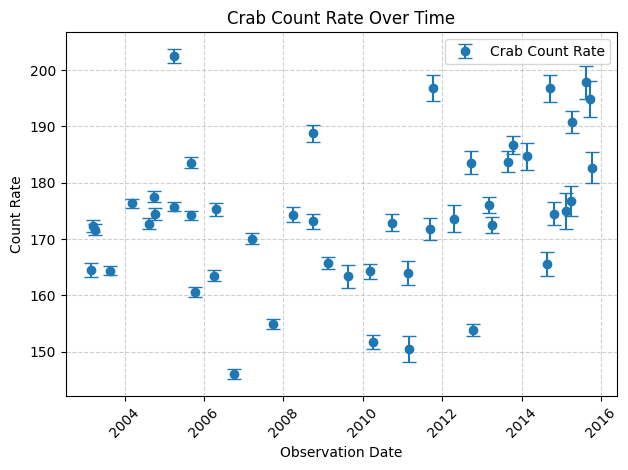

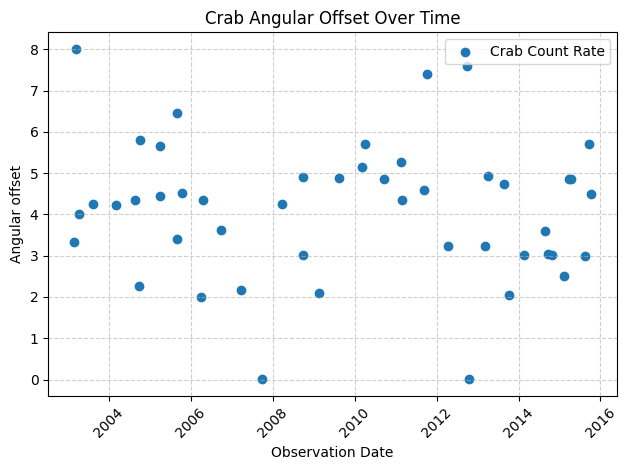

In [11]:
from datetime import datetime

obs_times = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S") for date in obs_start_dates]

crab_countrates = np.array(crab_countrates)
crab_variances = np.array(crab_variances)
errors = np.sqrt(crab_variances)
offsets = np.array(offsets)

# Plot count rate over time with errorbars
plt.figure()
plt.errorbar(obs_times, crab_countrates, yerr=errors, fmt='o', capsize=5, label="Crab Count Rate")
plt.xlabel("Observation Date")
plt.ylabel("Count Rate")
plt.title("Crab Count Rate Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# Plot angular offset from pointing center over time
plt.figure()
plt.scatter(obs_times, offsets, label="Crab Count Rate")
plt.xlabel("Observation Date")
plt.ylabel("Angular offset")
plt.title("Crab Angular Offset Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

## LIGHT CURVE

In [6]:
api_cat={
    "cat_frame": "fk5",
    "cat_coord_units": "deg",
    "cat_column_list": [
        [0],
        ["Crab"],
        [125.4826889038086],
        [ra],
        [dec],
        [-32768],
        [2],
        [0],
        [0.0002800000074785203]],
    "cat_column_names": [
        "meta_ID",
        "src_names",
        "significance",
        "ra",
        "dec",
        "NEW_SOURCE",
        "ISGRI_FLAG",
        "FLAG",
        "ERR_RAD"
    ],
    "cat_column_descr":
        [
            ["meta_ID", "<i8"],
            ["src_names", "<U11"],
            ["significance", "<f8"],
            ["ra", "<f8"],
            ["dec", "<f8"],
            ["NEW_SOURCE", "<i8"],
            ["ISGRI_FLAG", "<i8"],
            ["FLAG", "<i8"],
            ["ERR_RAD", "<f8"]
        ],
    "cat_lat_name": "dec",
    "cat_lon_name": "ra"
}

In [ ]:
lc_disp_by_date = {}
lc_data_by_date = {}

while True:
    lightcurve_results = []

    for year_month in set(year_months):

        filtered_scws = []
        for i, year_month_in_list in enumerate(year_months):
            if year_month_in_list == year_month:
                filtered_scws.append((scw[i], isot_start_times[i], isot_end_times[i], duration_seconds[i]))

        if not filtered_scws:
            print(f"No SCWs found for {year_month}")
            continue

        min_duration_scw = min(filtered_scws, key=lambda x: x[3]) # minimum duration
        scw_id, start_time, end_time, duration = min_duration_scw

        par_dict = {
            "RA": ra,
            "DEC": dec,
            "E1_keV": "15",
            "E2_keV": "30", 
            "T_format": "isot",
            'T1': start_time,
            'T2': end_time,
            "time_bin": duration_seconds, 
            "instrument": "isgri",
            "osa_version": "OSA11.2",
            "product": "isgri_lc",
            "product_type": "Real",
            "scw_list": [scw_id],
            'token': oda_api.token.discover_token(),
            'selected_catalog': json.dumps(api_cat)
            }
        
        if scw_id not in lc_disp_by_date:
            lc_disp_by_date[scw_id] = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock", wait=False)
        
        _disp = lc_disp_by_date[scw_id]
        
        data = lc_data_by_date.get(scw_id, None)

        if data is None and not _disp.is_failed:
            if not _disp.is_submitted:
                data = _disp.get_product(**par_dict, silent=True)
            else:
                _disp.poll()

            print("Is complete ", _disp.is_complete)
            if not _disp.is_complete:
                continue
            else:
                data = _disp.get_product(**par_dict)
                lc_data_by_date[scw_id] = data

        lightcurve_results.append(data)

    n_complete = len([ year for year, _disp in lc_disp_by_date.items() if _disp.is_complete ])
    print(f"complete {n_complete} / {len(lc_disp_by_date)}")
    if n_complete == len(lc_disp_by_date):
        print("done!")
        break
    print("not done")

Light curve analysis.

In [ ]:
from datetime import datetime

crab_lc_countrates = []
crab_lc_errors = []
lc_start_dates = []
lc_end_dates = []

for result in lightcurve_results:

    lc = result._p_list[0]

    start_time = lc.data_unit[1].data['TSTART']
    end_time = lc.data_unit[1].data['TSTOP']
    mjd_ref = lc.data_unit[1].header['MJDREF'] 
    start_date = [Time(mjd_ref + t, format='mjd').isot for t in start_time]
    end_date = [Time(mjd_ref + t, format='mjd').isot for t in end_time]

    rate = lc.data_unit[1].data['RATE']
    error = lc.data_unit[1].data['ERROR']

    crab_lc_countrates.append(rate)
    crab_lc_errors.append(error)
    lc_start_dates.append(start_date)
    lc_end_dates.append(end_date)

In [ ]:
output_lc_file = "../data/crab_lc_data.txt"

lc_data = np.column_stack([lc_start_dates, lc_end_dates, crab_lc_countrates, crab_lc_errors])

lc_header = "Obs Start Date, Obs End Date, Count Rate, Error"

np.savetxt(output_lc_file, lc_data, fmt="%s", delimiter=",", header=lc_header, comments="")

print(f"Data saved to {output_lc_file}")

In [ ]:
from datetime import datetime

lc_times = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S") for date in lc_start_dates]

lc_rates = np.array(crab_countrates)
lc_err = np.array(crab_lc_errors)

plt.figure()
plt.errorbar(lc_times, lc_rates, yerr=lc_err, fmt='o', capsize=5, label="Crab Count Rate")
plt.xlabel("Observation Date")
plt.ylabel("Count Rate")
plt.title("Crab Count Rate Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

## COMPARISON
Here we compare the count rate of the Crab over time between the two methods (using images or light curves).

In [ ]:
plt.figure()

plt.errorbar(obs_times, crab_countrates, yerr=errors, fmt='o', capsize=5, label="Images")
plt.errorbar(lc_times, lc_rates, yerr=lc_err, fmt='o', capsize=5, label="Light curves")

plt.xlabel("Observation Date")
plt.ylabel("Count Rate")
plt.title("Crab Count Rate Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()